# Extra Features:

In [8]:
import collections
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os
from sklearn.metrics import roc_curve, auc

# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, collections.Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)

# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low

In [9]:
import sklearn.feature_extraction.text as sk_text
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from pandas import Series
%matplotlib inline
import json
import csv
import pandas as pd

In [10]:
filename_read = 'TSLA_data.csv'
df = pd.read_csv(filename_read, na_values=['NA','?'])

In [11]:
df.head()

,High,Low,Open,Close,Volume
0,25.00,17.540001,19.000000,23.889999,18766300
1,30.42,23.299999,25.790001,23.830000,17187100
2,25.92,20.270000,25.000000,21.959999,8218800
3,23.10,18.709999,23.000000,19.200001,5139800
4,20.00,15.830000,20.000000,16.110001,6866900


In [12]:
df[df.isnull().any(axis=1)]

,High,Low,Open,Close,Volume


# Feature Normalization using min_max function

In [13]:
max = df['Volume'].max()
min = df['Volume'].min()
df['normalized_Volume'] = (df['Volume'] - min)/(max - min)

In [14]:
max = df['Open'].max()
min = df['Open'].min()
df['normalized_Open'] = (df['Open'] - min)/(max - min)

In [15]:
max = df['High'].max()
min = df['High'].min()
df['normalized_High'] = (df['High'] - min)/(max - min)

In [16]:
max = df['Low'].max()
min = df['Low'].min()
df['normalized_Low'] = (df['Low'] - min)/(max - min)

In [17]:
for i in df.columns:
    print(i, df[i].min(), df[i].max(), df[i].unique().shape)

High 16.62999916 389.60998539999997 (1841,)
Low 14.97999954 379.35000610000003 (1837,)
Open 16.13999939 386.69000239999997 (1830,)
Close 15.80000019 385.0 (1906,)
Volume 118500 37163900 (2059,)
normalized_Volume 0.0 1.0 (2059,)
normalized_Open 0.0 1.0 (1830,)
normalized_High 0.0 1.0 (1841,)
normalized_Low 0.0 1.0 (1837,)


High


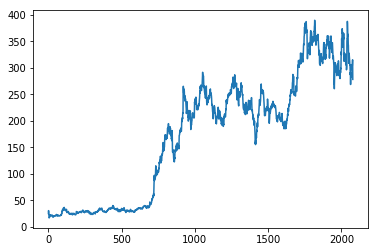

Low


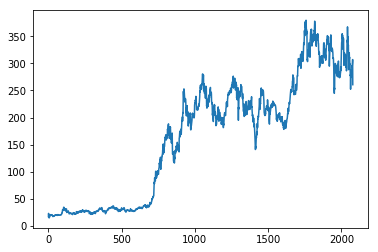

Open


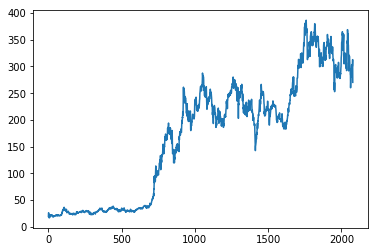

Close


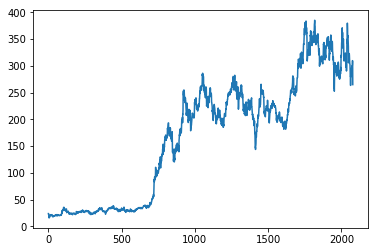

Volume


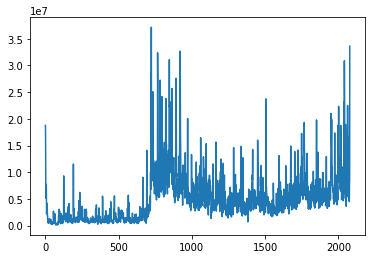

normalized_Volume


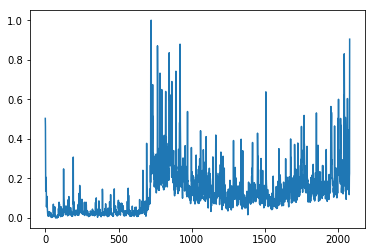

normalized_Open


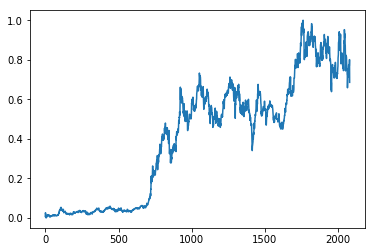

normalized_High


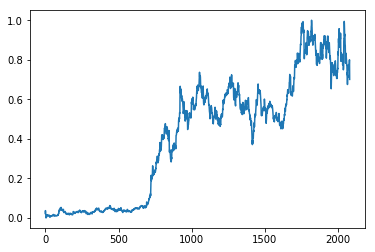

normalized_Low


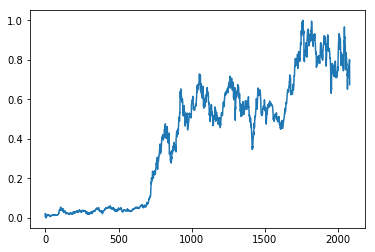

In [18]:
for i in df.columns:
    print(i)
    df[i].plot()
    plt.show()


In [19]:
df.drop(columns=['Volume','High','Low','Open'],inplace=True)

In [20]:
df.head()

,Close,normalized_Volume,normalized_Open,normalized_High,normalized_Low
0,23.889999,0.503377,0.007718,0.022441,0.007026
1,23.830000,0.460748,0.026042,0.036972,0.022834
2,21.959999,0.218659,0.023910,0.024908,0.014518
3,19.200001,0.135544,0.018513,0.017347,0.010237
4,16.110001,0.182166,0.010417,0.009035,0.002333


In [21]:
def print_reg_eval(pred,true):
    score = metrics.mean_squared_error(pred,true)
    print("Final score (MSE): {}".format(score))
    score = np.sqrt(metrics.mean_squared_error(pred,true))
    print("Final score (RMSE): {}".format(score))
    chart_regression(pred.flatten(),true)

# Fully Connected Artificial Neural Network

C:\Users\rutwi\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Train on 1455 samples, validate on 624 samples
Epoch 1/100
 - 0s - loss: 41437.8610 - val_loss: 39983.0448
Epoch 2/100
 - 0s - loss: 41039.8499 - val_loss: 39392.7529
Epoch 3/100
 - 0s - loss: 40134.1471 - val_loss: 38176.7743
Epoch 4/100
 - 0s - loss: 38394.8533 - val_loss: 35937.1247
Epoch 5/100
 - 0s - loss: 35387.1590 - val_loss: 32277.6215
Epoch 6/100
 - 0s - loss: 30920.9464 - val_loss: 27219.6695
Epoch 7/100
 - 0s - loss: 25184.7048 - val_loss: 21242.7200
Epoch 8/100
 - 0s - loss: 18800.4335 - val_loss: 15031.2802
Epoch 9/100
 - 0s - loss: 12621.8219 - val_loss: 9535.5489
Epoch 10/100
 - 0s - loss: 7634.2627 - val_loss: 5485.2206
Epoch 11/100
 - 0s - loss: 4332.0045 - val_loss: 3185.4581
Epoch 12/100
 - 0s - loss: 2640.1464 - val_loss: 2133.1585
Epoch 13/100
 - 0s - loss: 1925.5463 - val_loss: 1738.4286
Epoch 14/100
 - 0s - loss: 1653.0803 - val_loss: 1572.8277
Epoch 15/100
 - 0s - loss: 1522.8278 - val_loss: 1465.8710
Epoch 16/100
 - 0s - loss: 1424.5957 - val_loss: 1369.3742
E

Epoch 52/100
 - 0s - loss: 10.4451 - val_loss: 8.9946
Epoch 53/100
 - 0s - loss: 10.3821 - val_loss: 9.0957
Epoch 54/100
 - 0s - loss: 10.3404 - val_loss: 9.0263
Epoch 55/100
 - 0s - loss: 10.4984 - val_loss: 9.0196
Epoch 56/100
 - 0s - loss: 10.4852 - val_loss: 8.9717
Epoch 57/100
 - 0s - loss: 10.3609 - val_loss: 8.9567
Epoch 58/100
 - 0s - loss: 10.3555 - val_loss: 8.9382
Epoch 59/100
 - 0s - loss: 10.3412 - val_loss: 8.9321
Epoch 60/100
 - 0s - loss: 10.3030 - val_loss: 9.4233
Epoch 61/100
 - 0s - loss: 10.3283 - val_loss: 8.9523
Epoch 62/100
 - 0s - loss: 10.2974 - val_loss: 8.9199
Epoch 63/100
 - 0s - loss: 10.4298 - val_loss: 8.9254
Epoch 64/100
 - 0s - loss: 10.3575 - val_loss: 9.4128
Epoch 65/100
 - 0s - loss: 10.3218 - val_loss: 9.0249
Epoch 66/100
 - 0s - loss: 10.3682 - val_loss: 9.0869
Epoch 67/100
 - 0s - loss: 10.3289 - val_loss: 8.8868
Epoch 68/100
 - 0s - loss: 10.3476 - val_loss: 8.8851
Epoch 69/100
 - 0s - loss: 10.2353 - val_loss: 8.9510
Epoch 70/100
 - 0s - loss: 1

 - 0s - loss: 23.1903 - val_loss: 18.1305
Epoch 40/100
 - 0s - loss: 21.5483 - val_loss: 17.1086
Epoch 41/100
 - 0s - loss: 20.1879 - val_loss: 16.2950
Epoch 42/100
 - 0s - loss: 19.1445 - val_loss: 15.4500
Epoch 43/100
 - 0s - loss: 18.1648 - val_loss: 14.7410
Epoch 44/100
 - 0s - loss: 17.3290 - val_loss: 14.2451
Epoch 45/100
 - 0s - loss: 16.6057 - val_loss: 13.6272
Epoch 46/100
 - 0s - loss: 15.8813 - val_loss: 13.2701
Epoch 47/100
 - 0s - loss: 15.3007 - val_loss: 12.7227
Epoch 48/100
 - 0s - loss: 14.8103 - val_loss: 12.3386
Epoch 49/100
 - 0s - loss: 14.2727 - val_loss: 12.0534
Epoch 50/100
 - 0s - loss: 13.8524 - val_loss: 11.6876
Epoch 51/100
 - 0s - loss: 13.4567 - val_loss: 11.4260
Epoch 52/100
 - 0s - loss: 13.1156 - val_loss: 11.1152
Epoch 53/100
 - 0s - loss: 12.8548 - val_loss: 11.0384
Epoch 54/100
 - 0s - loss: 12.5102 - val_loss: 10.6642
Epoch 55/100
 - 0s - loss: 12.3239 - val_loss: 10.6786
Epoch 56/100
 - 0s - loss: 12.0176 - val_loss: 10.2756
Epoch 57/100
 - 0s - lo

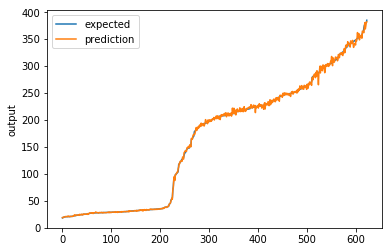

In [22]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import os
import io
import requests
from sklearn import metrics

x,y = to_xy(df, 'Close')
x_train_ann, x_test_ann, y_train_ann, y_test_ann = train_test_split(x, y, test_size=0.3, random_state=42)
checkpointer = ModelCheckpoint(filepath="best_weights_ann.hdf5", verbose=0, save_best_only=True) # save best model
for i in range(5):
    model = Sequential()
    model.add(Dense(30, input_dim=x.shape[1], activation='relu')) # Hidden 1
    model.add(Dense(15, activation='relu')) # Hidden 2
    model.add(Dense(1)) # Output
    model.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')
    model.fit(x_train_ann, y_train_ann, validation_data=(x_test_ann,y_test_ann), callbacks=[monitor,checkpointer], verbose=2, epochs=100)  

model.load_weights('best_weights_ann.hdf5')
pred = model.predict(x_test_ann)
print_reg_eval(pred,y_test_ann)

# Hypertuning on parameters for Fully Connected Network

Train on 1455 samples, validate on 624 samples
Epoch 1/100
 - 1s - loss: 41079.2596 - val_loss: 39428.7157
Epoch 2/100
 - 0s - loss: 40420.5029 - val_loss: 38852.0994
Epoch 3/100
 - 0s - loss: 39904.1803 - val_loss: 38423.1646
Epoch 4/100
 - 0s - loss: 39509.7554 - val_loss: 38080.7431
Epoch 5/100
 - 0s - loss: 39178.0287 - val_loss: 37776.2246
Epoch 6/100
 - 0s - loss: 38877.4500 - val_loss: 37490.9320
Epoch 7/100
 - 0s - loss: 38590.2610 - val_loss: 37211.2004
Epoch 8/100
 - 0s - loss: 38290.5884 - val_loss: 36908.3312
Epoch 9/100
 - 0s - loss: 37982.6815 - val_loss: 36615.2258
Epoch 10/100
 - 0s - loss: 37691.3545 - val_loss: 36340.5590
Epoch 11/100
 - 0s - loss: 37412.3322 - val_loss: 36070.3604
Epoch 12/100
 - 0s - loss: 37137.1431 - val_loss: 35812.0565
Epoch 13/100
 - 0s - loss: 36870.7148 - val_loss: 35551.2122
Epoch 14/100
 - 0s - loss: 36606.6987 - val_loss: 35300.1369
Epoch 15/100
 - 0s - loss: 36348.1990 - val_loss: 35051.9249
Epoch 16/100
 - 0s - loss: 36093.3373 - val_los

 - 0s - loss: 31265.1515 - val_loss: 30130.9997
Epoch 35/100
 - 0s - loss: 31023.3695 - val_loss: 29895.5547
Epoch 36/100
 - 0s - loss: 30782.6954 - val_loss: 29667.8624
Epoch 37/100
 - 0s - loss: 30546.8521 - val_loss: 29439.8910
Epoch 38/100
 - 0s - loss: 30313.8479 - val_loss: 29215.7745
Epoch 39/100
 - 0s - loss: 30083.1690 - val_loss: 28997.6237
Epoch 40/100
 - 0s - loss: 29855.4586 - val_loss: 28777.8759
Epoch 41/100
 - 0s - loss: 29630.9793 - val_loss: 28562.1680
Epoch 42/100
 - 0s - loss: 29408.3995 - val_loss: 28348.5439
Epoch 43/100
 - 0s - loss: 29188.6175 - val_loss: 28136.2408
Epoch 44/100
 - 0s - loss: 28970.9005 - val_loss: 27928.0498
Epoch 45/100
 - 0s - loss: 28756.2832 - val_loss: 27721.3107
Epoch 46/100
 - 0s - loss: 28542.9897 - val_loss: 27515.6841
Epoch 47/100
 - 0s - loss: 28331.8633 - val_loss: 27314.5335
Epoch 48/100
 - 0s - loss: 28123.2440 - val_loss: 27114.8312
Epoch 49/100
 - 0s - loss: 27916.2615 - val_loss: 26916.1419
Epoch 50/100
 - 0s - loss: 27711.8827

Epoch 68/100
 - 0s - loss: 25806.2290 - val_loss: 24905.5678
Epoch 69/100
 - 0s - loss: 25641.2877 - val_loss: 24745.5836
Epoch 70/100
 - 0s - loss: 25476.0059 - val_loss: 24589.4588
Epoch 71/100
 - 0s - loss: 25312.8802 - val_loss: 24433.3541
Epoch 72/100
 - 0s - loss: 25150.9196 - val_loss: 24279.5802
Epoch 73/100
 - 0s - loss: 24990.9722 - val_loss: 24123.4537
Epoch 74/100
 - 0s - loss: 24830.6772 - val_loss: 23971.9930
Epoch 75/100
 - 0s - loss: 24672.5756 - val_loss: 23822.8993
Epoch 76/100
 - 0s - loss: 24515.6844 - val_loss: 23672.6019
Epoch 77/100
 - 0s - loss: 24359.7434 - val_loss: 23522.6634
Epoch 78/100
 - 0s - loss: 24206.1405 - val_loss: 23375.5173
Epoch 79/100
 - 0s - loss: 24053.1642 - val_loss: 23230.5854
Epoch 80/100
 - 0s - loss: 23902.4732 - val_loss: 23087.1120
Epoch 81/100
 - 0s - loss: 23752.4288 - val_loss: 22944.4578
Epoch 82/100
 - 0s - loss: 23603.7715 - val_loss: 22800.9710
Epoch 83/100
 - 0s - loss: 23455.0612 - val_loss: 22662.3047
Epoch 84/100
 - 0s - los

 - 1s - loss: 41726.3339 - val_loss: 40120.7778
Epoch 2/100
 - 0s - loss: 41197.1744 - val_loss: 39675.4825
Epoch 3/100
 - 0s - loss: 40794.9576 - val_loss: 39327.2472
Epoch 4/100
 - 0s - loss: 40466.3399 - val_loss: 39034.7614
Epoch 5/100
 - 0s - loss: 40188.9380 - val_loss: 38788.6068
Epoch 6/100
 - 0s - loss: 39950.7292 - val_loss: 38568.7042
Epoch 7/100
 - 0s - loss: 39731.7921 - val_loss: 38361.8029
Epoch 8/100
 - 0s - loss: 39524.3682 - val_loss: 38164.9028
Epoch 9/100
 - 0s - loss: 39324.4972 - val_loss: 37970.4134
Epoch 10/100
 - 0s - loss: 39128.9792 - val_loss: 37784.7711
Epoch 11/100
 - 0s - loss: 38937.9274 - val_loss: 37600.8563
Epoch 12/100
 - 0s - loss: 38750.2798 - val_loss: 37419.1653
Epoch 13/100
 - 0s - loss: 38564.9413 - val_loss: 37241.6954
Epoch 14/100
 - 0s - loss: 38382.2242 - val_loss: 37064.5920
Epoch 15/100
 - 0s - loss: 38201.3952 - val_loss: 36891.3583
Epoch 16/100
 - 0s - loss: 38023.3233 - val_loss: 36716.3586
Epoch 17/100
 - 0s - loss: 37845.6397 - val_l

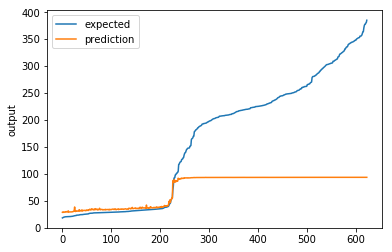

In [24]:
checkpointer = ModelCheckpoint(filepath="best_weights_ann1.hdf5", verbose=0, save_best_only=True) # save best model
for i in range(5):
    model = Sequential()
    model.add(Dense(40, input_dim=x.shape[1], activation='sigmoid')) # Hidden 1
    model.add(Dense(25, activation='sigmoid')) # Hidden 2
    model.add(Dense(1)) # Output
    model.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')
    model.fit(x_train_ann, y_train_ann, validation_data=(x_test_ann,y_test_ann), callbacks=[monitor,checkpointer], verbose=2, epochs=100)  

model.load_weights('best_weights_ann1.hdf5')
pred = model.predict(x_test_ann)
print_reg_eval(pred,y_test_ann)

Train on 1455 samples, validate on 624 samples
Epoch 1/100
 - 0s - loss: 14872.3903 - val_loss: 13149.4256
Epoch 2/100
 - 0s - loss: 12870.8898 - val_loss: 13020.5273
Epoch 3/100
 - 0s - loss: 12918.4543 - val_loss: 13021.1240
Epoch 4/100
 - 0s - loss: 12916.9382 - val_loss: 13281.6863
Epoch 5/100
 - 0s - loss: 12970.1682 - val_loss: 13023.8236
Epoch 6/100
 - 0s - loss: 12878.1474 - val_loss: 13028.1593
Epoch 7/100
 - 0s - loss: 12930.9509 - val_loss: 13033.1716
Epoch 00007: early stopping
Train on 1455 samples, validate on 624 samples
Epoch 1/100
 - 0s - loss: 14961.8620 - val_loss: 13018.6287
Epoch 2/100
 - 0s - loss: 12906.8887 - val_loss: 13188.5061
Epoch 3/100
 - 0s - loss: 12899.7521 - val_loss: 13029.2175
Epoch 4/100
 - 0s - loss: 12918.4571 - val_loss: 13138.0788
Epoch 5/100
 - 0s - loss: 12878.7881 - val_loss: 13115.9129
Epoch 6/100
 - 0s - loss: 12884.3768 - val_loss: 13042.6058
Epoch 00006: early stopping
Train on 1455 samples, validate on 624 samples
Epoch 1/100
 - 0s - los

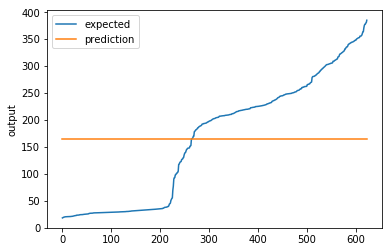

In [23]:
checkpointer = ModelCheckpoint(filepath="best_weights_ann2.hdf5", verbose=0, save_best_only=True) # save best model
for i in range(5):
    model = Sequential()
    model.add(Dense(30, input_dim=x.shape[1], activation='sigmoid')) # Hidden 1
    model.add(Dense(20, activation='relu')) # Hidden 1
    model.add(Dense(10, activation='tanh')) # Hidden 2
    model.add(Dense(1)) # Output
    model.compile(loss='mean_squared_error', optimizer='sgd')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')
    model.fit(x_train_ann, y_train_ann, validation_data=(x_test_ann,y_test_ann), callbacks=[monitor,checkpointer], verbose=2, epochs=100)  

model.load_weights('best_weights_ann2.hdf5')
pred = model.predict(x_test_ann)
print_reg_eval(pred,y_test_ann)

Train on 1455 samples, validate on 624 samples
Epoch 1/100
 - 0s - loss: 40243.7701 - val_loss: 38295.0994
Epoch 2/100
 - 0s - loss: 39190.2073 - val_loss: 37641.4471
Epoch 3/100
 - 0s - loss: 38662.9492 - val_loss: 37213.9772
Epoch 4/100
 - 0s - loss: 38253.3292 - val_loss: 36836.5735
Epoch 5/100
 - 0s - loss: 37870.2925 - val_loss: 36467.3038
Epoch 6/100
 - 0s - loss: 37495.8915 - val_loss: 36106.0874
Epoch 7/100
 - 0s - loss: 37123.6264 - val_loss: 35750.0849
Epoch 8/100
 - 0s - loss: 36758.2206 - val_loss: 35391.4355
Epoch 9/100
 - 0s - loss: 36392.0872 - val_loss: 35041.5644
Epoch 10/100
 - 0s - loss: 36028.2450 - val_loss: 34686.1757
Epoch 11/100
 - 0s - loss: 35673.1301 - val_loss: 34345.1632
Epoch 12/100
 - 0s - loss: 35317.4099 - val_loss: 34003.2265
Epoch 13/100
 - 0s - loss: 34964.6703 - val_loss: 33658.2497
Epoch 14/100
 - 0s - loss: 34615.2687 - val_loss: 33321.7257
Epoch 15/100
 - 0s - loss: 34264.5522 - val_loss: 32984.4349
Epoch 16/100
 - 0s - loss: 33921.3764 - val_los

Epoch 35/100
 - 0s - loss: 27738.2305 - val_loss: 26697.8948
Epoch 36/100
 - 0s - loss: 27445.6012 - val_loss: 26413.8470
Epoch 37/100
 - 0s - loss: 27154.3474 - val_loss: 26130.0867
Epoch 38/100
 - 0s - loss: 26855.8190 - val_loss: 25837.5618
Epoch 39/100
 - 0s - loss: 26553.2228 - val_loss: 25541.5010
Epoch 40/100
 - 0s - loss: 26250.3150 - val_loss: 25243.8147
Epoch 41/100
 - 0s - loss: 25940.4882 - val_loss: 24941.9842
Epoch 42/100
 - 0s - loss: 25630.2912 - val_loss: 24640.1381
Epoch 43/100
 - 0s - loss: 25323.4497 - val_loss: 24344.1989
Epoch 44/100
 - 0s - loss: 25016.9880 - val_loss: 24052.8008
Epoch 45/100
 - 0s - loss: 24719.1931 - val_loss: 23764.7907
Epoch 46/100
 - 0s - loss: 24427.6298 - val_loss: 23487.6328
Epoch 47/100
 - 0s - loss: 24144.1743 - val_loss: 23214.9071
Epoch 48/100
 - 0s - loss: 23862.9000 - val_loss: 22946.7279
Epoch 49/100
 - 0s - loss: 23582.7856 - val_loss: 22672.3932
Epoch 50/100
 - 0s - loss: 23306.2247 - val_loss: 22404.6117
Epoch 51/100
 - 0s - los

Epoch 69/100
 - 0s - loss: 18416.0431 - val_loss: 17686.3817
Epoch 70/100
 - 0s - loss: 18175.1238 - val_loss: 17455.7469
Epoch 71/100
 - 0s - loss: 17937.9999 - val_loss: 17225.4619
Epoch 72/100
 - 0s - loss: 17700.8157 - val_loss: 16997.2129
Epoch 73/100
 - 0s - loss: 17467.4033 - val_loss: 16769.1810
Epoch 74/100
 - 0s - loss: 17233.4210 - val_loss: 16547.2751
Epoch 75/100
 - 0s - loss: 17005.9667 - val_loss: 16328.1036
Epoch 76/100
 - 0s - loss: 16782.6362 - val_loss: 16110.1048
Epoch 77/100
 - 0s - loss: 16555.2520 - val_loss: 15892.4563
Epoch 78/100
 - 0s - loss: 16330.6212 - val_loss: 15673.0766
Epoch 79/100
 - 0s - loss: 16109.5992 - val_loss: 15460.5118
Epoch 80/100
 - 0s - loss: 15889.6815 - val_loss: 15247.2759
Epoch 81/100
 - 0s - loss: 15670.5492 - val_loss: 15036.6735
Epoch 82/100
 - 0s - loss: 15453.8933 - val_loss: 14828.5008
Epoch 83/100
 - 0s - loss: 15238.9021 - val_loss: 14619.0945
Epoch 84/100
 - 0s - loss: 15024.0209 - val_loss: 14412.1683
Epoch 85/100
 - 0s - los

Epoch 2/100
 - 0s - loss: 39254.8062 - val_loss: 37697.6572
Epoch 3/100
 - 0s - loss: 38718.2791 - val_loss: 37268.2936
Epoch 4/100
 - 0s - loss: 38308.4051 - val_loss: 36889.4688
Epoch 5/100
 - 0s - loss: 37929.7086 - val_loss: 36527.4124
Epoch 6/100
 - 0s - loss: 37556.3705 - val_loss: 36165.4244
Epoch 7/100
 - 0s - loss: 37183.4464 - val_loss: 35803.5849
Epoch 8/100
 - 0s - loss: 36817.6831 - val_loss: 35450.1832
Epoch 9/100
 - 0s - loss: 36451.3183 - val_loss: 35096.4337
Epoch 10/100
 - 0s - loss: 36089.1413 - val_loss: 34745.0129
Epoch 11/100
 - 0s - loss: 35728.4625 - val_loss: 34399.4677
Epoch 12/100
 - 0s - loss: 35373.7658 - val_loss: 34053.8447
Epoch 13/100
 - 0s - loss: 35021.3185 - val_loss: 33715.3413
Epoch 14/100
 - 0s - loss: 34672.0788 - val_loss: 33375.2733
Epoch 15/100
 - 0s - loss: 34323.1841 - val_loss: 33039.0469
Epoch 16/100
 - 0s - loss: 33974.4408 - val_loss: 32706.1280
Epoch 17/100
 - 0s - loss: 33635.7849 - val_loss: 32375.9786
Epoch 18/100
 - 0s - loss: 33296

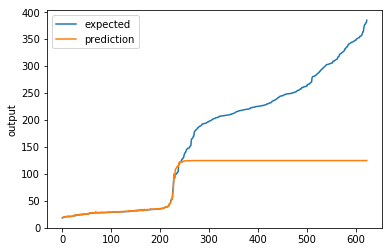

In [24]:
checkpointer = ModelCheckpoint(filepath="best_weights_ann3.hdf5", verbose=0, save_best_only=True) # save best model
for i in range(5):
    model = Sequential()
    model.add(Dense(50, input_dim=x.shape[1], activation='sigmoid')) # Hidden 1
    model.add(Dense(25, activation='tanh')) # Hidden 2
    model.add(Dense(1)) # Output
    model.compile(loss='mean_squared_error', optimizer='rmsprop')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')
    model.fit(x_train_ann, y_train_ann, validation_data=(x_test_ann,y_test_ann), callbacks=[monitor,checkpointer], verbose=2, epochs=100)  

model.load_weights('best_weights_ann3.hdf5')
pred = model.predict(x_test_ann)
print_reg_eval(pred,y_test_ann)

Train on 1455 samples, validate on 624 samples
Epoch 1/100
 - 1s - loss: 13824.0489 - val_loss: 13829.5210
Epoch 2/100
 - 0s - loss: 12942.8507 - val_loss: 13063.7744
Epoch 3/100
 - 0s - loss: 12927.1683 - val_loss: 13032.7171
Epoch 4/100
 - 0s - loss: 12885.9530 - val_loss: 13279.5694
Epoch 5/100
 - 0s - loss: 12979.4957 - val_loss: 13477.4600
Epoch 6/100
 - 0s - loss: 12980.8440 - val_loss: 13037.7617
Epoch 7/100
 - 0s - loss: 12945.6162 - val_loss: 13099.8538
Epoch 8/100
 - 0s - loss: 13000.6533 - val_loss: 13053.4348
Epoch 00008: early stopping
Train on 1455 samples, validate on 624 samples
Epoch 1/100
 - 1s - loss: 14107.4065 - val_loss: 13555.4364
Epoch 2/100
 - 0s - loss: 12961.1939 - val_loss: 14342.7453
Epoch 3/100
 - 0s - loss: 13144.5348 - val_loss: 13054.6492
Epoch 4/100
 - 0s - loss: 12903.8965 - val_loss: 13166.9668
Epoch 5/100
 - 0s - loss: 12971.3380 - val_loss: 13338.5605
Epoch 6/100
 - 0s - loss: 13004.2268 - val_loss: 13052.4064
Epoch 7/100
 - 0s - loss: 13058.8692 -

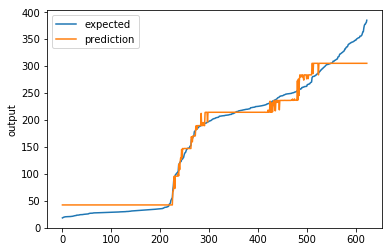

In [25]:
checkpointer = ModelCheckpoint(filepath="best_weights_ann4.hdf5", verbose=0, save_best_only=True) # save best model
for i in range(5):
    model = Sequential()
    model.add(Dense(40, input_dim=x.shape[1], activation='relu')) # Hidden 1
    model.add(Dense(25, activation='sigmoid')) # Hidden 2
    model.add(Dense(1)) # Output
    model.compile(loss='mean_squared_error', optimizer='sgd')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')
    model.fit(x_train_ann, y_train_ann, validation_data=(x_test_ann,y_test_ann), callbacks=[monitor,checkpointer], verbose=2, epochs=100)  

model.load_weights('best_weights_ann4.hdf5')
pred = model.predict(x_test_ann)
print_reg_eval(pred,y_test_ann)

Train on 1455 samples, validate on 624 samples
Epoch 1/100
 - 1s - loss: 41055.5239 - val_loss: 39683.3520
Epoch 2/100
 - 0s - loss: 40913.4475 - val_loss: 39549.0201
Epoch 3/100
 - 0s - loss: 40771.2421 - val_loss: 39403.8864
Epoch 4/100
 - 0s - loss: 40619.9032 - val_loss: 39255.5465
Epoch 5/100
 - 0s - loss: 40467.8120 - val_loss: 39111.0851
Epoch 6/100
 - 0s - loss: 40325.0479 - val_loss: 38979.2307
Epoch 7/100
 - 0s - loss: 40196.9937 - val_loss: 38861.9941
Epoch 8/100
 - 0s - loss: 40082.3824 - val_loss: 38755.6673
Epoch 9/100
 - 0s - loss: 39976.1929 - val_loss: 38654.7623
Epoch 10/100
 - 0s - loss: 39875.8200 - val_loss: 38558.5318
Epoch 11/100
 - 0s - loss: 39777.4104 - val_loss: 38462.3783
Epoch 12/100
 - 0s - loss: 39678.0523 - val_loss: 38366.0439
Epoch 13/100
 - 0s - loss: 39580.5041 - val_loss: 38272.0768
Epoch 14/100
 - 0s - loss: 39484.0007 - val_loss: 38178.2665
Epoch 15/100
 - 0s - loss: 39388.5498 - val_loss: 38086.1884
Epoch 16/100
 - 0s - loss: 39295.7427 - val_los

 - 0s - loss: 38756.5029 - val_loss: 37461.5579
Epoch 35/100
 - 0s - loss: 38642.1690 - val_loss: 37350.9101
Epoch 36/100
 - 0s - loss: 38528.4026 - val_loss: 37241.1210
Epoch 37/100
 - 0s - loss: 38418.8129 - val_loss: 37138.5678
Epoch 38/100
 - 0s - loss: 38316.5291 - val_loss: 37040.8033
Epoch 39/100
 - 0s - loss: 38217.9611 - val_loss: 36947.8635
Epoch 40/100
 - 0s - loss: 38123.4150 - val_loss: 36856.4902
Epoch 41/100
 - 0s - loss: 38031.3803 - val_loss: 36768.5621
Epoch 42/100
 - 0s - loss: 37941.9943 - val_loss: 36682.2588
Epoch 43/100
 - 0s - loss: 37853.5195 - val_loss: 36596.8690
Epoch 44/100
 - 0s - loss: 37765.5347 - val_loss: 36511.7815
Epoch 45/100
 - 0s - loss: 37678.8426 - val_loss: 36428.0143
Epoch 46/100
 - 0s - loss: 37592.3324 - val_loss: 36343.8733
Epoch 47/100
 - 0s - loss: 37506.2177 - val_loss: 36260.1005
Epoch 48/100
 - 0s - loss: 37420.1060 - val_loss: 36176.8377
Epoch 49/100
 - 0s - loss: 37333.7958 - val_loss: 36092.9038
Epoch 50/100
 - 0s - loss: 37248.2285

Epoch 68/100
 - 0s - loss: 35290.1360 - val_loss: 34110.6484
Epoch 69/100
 - 0s - loss: 35207.7600 - val_loss: 34031.2590
Epoch 70/100
 - 0s - loss: 35127.3277 - val_loss: 33953.1857
Epoch 71/100
 - 0s - loss: 35045.7792 - val_loss: 33873.6448
Epoch 72/100
 - 0s - loss: 34964.0951 - val_loss: 33794.2921
Epoch 73/100
 - 0s - loss: 34883.0039 - val_loss: 33715.5783
Epoch 74/100
 - 0s - loss: 34800.9089 - val_loss: 33636.4528
Epoch 75/100
 - 0s - loss: 34720.9645 - val_loss: 33559.4073
Epoch 76/100
 - 0s - loss: 34639.9023 - val_loss: 33480.3746
Epoch 77/100
 - 0s - loss: 34559.0083 - val_loss: 33401.7328
Epoch 78/100
 - 0s - loss: 34478.7299 - val_loss: 33324.2211
Epoch 79/100
 - 0s - loss: 34398.0279 - val_loss: 33246.1050
Epoch 80/100
 - 0s - loss: 34317.3079 - val_loss: 33168.5907
Epoch 81/100
 - 0s - loss: 34238.9695 - val_loss: 33092.3620
Epoch 82/100
 - 0s - loss: 34158.6171 - val_loss: 33014.2302
Epoch 83/100
 - 0s - loss: 34079.2038 - val_loss: 32937.6361
Epoch 84/100
 - 0s - los

 - 1s - loss: 41213.1881 - val_loss: 39851.3316
Epoch 2/100
 - 0s - loss: 41098.7632 - val_loss: 39737.9718
Epoch 3/100
 - 0s - loss: 40976.8101 - val_loss: 39615.7178
Epoch 4/100
 - 0s - loss: 40848.7793 - val_loss: 39491.7288
Epoch 5/100
 - 0s - loss: 40722.2801 - val_loss: 39370.2734
Epoch 6/100
 - 0s - loss: 40601.6175 - val_loss: 39257.9720
Epoch 7/100
 - 0s - loss: 40490.8044 - val_loss: 39154.0791
Epoch 8/100
 - 0s - loss: 40388.0836 - val_loss: 39058.3031
Epoch 9/100
 - 0s - loss: 40293.8797 - val_loss: 38968.3603
Epoch 10/100
 - 0s - loss: 40201.3421 - val_loss: 38879.9972
Epoch 11/100
 - 0s - loss: 40113.5895 - val_loss: 38794.8157
Epoch 12/100
 - 0s - loss: 40024.1109 - val_loss: 38706.1093
Epoch 13/100
 - 0s - loss: 39931.0062 - val_loss: 38613.4243
Epoch 14/100
 - 0s - loss: 39834.8125 - val_loss: 38517.8827
Epoch 15/100
 - 0s - loss: 39734.5990 - val_loss: 38419.6056
Epoch 16/100
 - 0s - loss: 39634.8014 - val_loss: 38323.0244
Epoch 17/100
 - 0s - loss: 39533.8491 - val_l

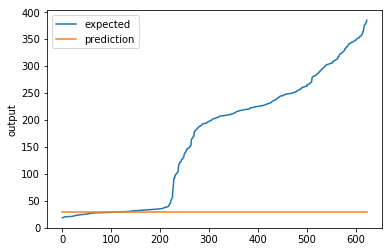

In [26]:
checkpointer = ModelCheckpoint(filepath="best_weights_ann5.hdf5", verbose=0, save_best_only=True) # save best model
for i in range(5):
    model = Sequential()
    model.add(Dense(10, input_dim=x.shape[1], activation='tanh')) # Hidden 1
    model.add(Dense(5, activation='sigmoid')) # Hidden 2
    model.add(Dense(1)) # Output
    model.compile(loss='mean_squared_error', optimizer='rmsprop')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')
    model.fit(x_train_ann, y_train_ann, validation_data=(x_test_ann,y_test_ann), callbacks=[monitor,checkpointer], verbose=2, epochs=100)  

model.load_weights('best_weights_ann5.hdf5')
pred = model.predict(x_test_ann)
print_reg_eval(pred,y_test_ann)

# Create x and y in the format RNN accepts

In [27]:
max = df['Close'].max()
min = df['Close'].min()
df['normalized_Close'] = (df['Close'] - min)/(max - min)

In [28]:
df.head()

,Close,normalized_Volume,normalized_Open,normalized_High,normalized_Low,normalized_Close
0,23.889999,0.503377,0.007718,0.022441,0.007026,0.021912
1,23.830000,0.460748,0.026042,0.036972,0.022834,0.021750
2,21.959999,0.218659,0.023910,0.024908,0.014518,0.016685
3,19.200001,0.135544,0.018513,0.017347,0.010237,0.009209
4,16.110001,0.182166,0.010417,0.009035,0.002333,0.000840


In [29]:
xarray=[]
xarray=df[['normalized_Open','normalized_High','normalized_Low','normalized_Volume','normalized_Close']].as_matrix()

C:\Users\rutwi\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [30]:
yarray=df[['Close']].as_matrix()

C:\Users\rutwi\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [31]:
SEQUENCE_SIZE = 7
import numpy as np

def to_sequences(seq_size, data,data2):
    x = []
    y = []

    for i in range(len(data)-SEQUENCE_SIZE-1):
        #print(i)
        window = data[i:(i+SEQUENCE_SIZE)]
        after_window = data2[i+SEQUENCE_SIZE]
        window = [[x] for x in window]
        #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)
        
    return np.array(x),np.array(y)

In [32]:
x,y = to_sequences(SEQUENCE_SIZE,xarray,yarray)

In [33]:
x_rnn = x.reshape(x.shape[0],7,5)

In [34]:
y_rnn = y.reshape(y.shape[0])

# LSTM - Ready to train a RNN model 

In [35]:
x_train_lstm = x_rnn[0:2800]
y_train_lstm = y_rnn[0:2800]
x_test_lstm = x_rnn[2800:4385]
y_test_lstm = y_rnn[2800:4385]

In [36]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import numpy as np

checkpointer = ModelCheckpoint(filepath="lstm/best_weights_lstm.hdf5", verbose=0, save_best_only=True) # save best model

print('Build model...')
for i in range(5):
    model = Sequential()
    model.add(LSTM(64, dropout=0.1, recurrent_dropout=0.1, input_shape=(7, 5)))
    model.add(Dense(32))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    print('Train...')
    model.fit(x_train_lstm,y_train_lstm,validation_data=(x_test_lstm,y_test_lstm),callbacks=[monitor,checkpointer],verbose=2, epochs=10)
    
model.load_weights('lstm/best_weights_lstm.hdf5')
pred = model.predict(x_test_lstm)
print_reg_eval(pred,y_test_lstm)

Build model...
Train...
Train on 2071 samples, validate on 0 samples
Epoch 1/10
 - 2s - loss: 36365.6275
Epoch 2/10


C:\Users\rutwi\Anaconda3\lib\site-packages\keras\callbacks.py:535: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
C:\Users\rutwi\Anaconda3\lib\site-packages\keras\callbacks.py:432: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


 - 0s - loss: 18758.7424
Epoch 3/10
 - 0s - loss: 6609.0195
Epoch 4/10
 - 0s - loss: 2418.4163
Epoch 5/10
 - 0s - loss: 1332.9516
Epoch 6/10
 - 0s - loss: 936.0547
Epoch 7/10
 - 0s - loss: 742.0128
Epoch 8/10
 - 0s - loss: 623.8110
Epoch 9/10
 - 0s - loss: 540.5750
Epoch 10/10
 - 0s - loss: 473.4231
Train...
Train on 2071 samples, validate on 0 samples
Epoch 1/10
 - 2s - loss: 36356.9099
Epoch 2/10
 - 0s - loss: 17833.8633
Epoch 3/10
 - 0s - loss: 5989.6676
Epoch 4/10
 - 0s - loss: 2190.2531
Epoch 5/10
 - 0s - loss: 1297.0184
Epoch 6/10
 - 0s - loss: 916.3702
Epoch 7/10
 - 0s - loss: 749.3148
Epoch 8/10
 - 0s - loss: 585.7696
Epoch 9/10
 - 0s - loss: 592.0591
Epoch 10/10
 - 0s - loss: 479.1913
Train...
Train on 2071 samples, validate on 0 samples
Epoch 1/10
 - 2s - loss: 36269.2487
Epoch 2/10
 - 0s - loss: 19326.4770
Epoch 3/10
 - 0s - loss: 7008.6426
Epoch 4/10
 - 0s - loss: 2489.0061
Epoch 5/10
 - 0s - loss: 1417.8424
Epoch 6/10
 - 0s - loss: 980.5672
Epoch 7/10
 - 0s - loss: 731.213

ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

# Hypertuning on parameters for LSTM

In [ ]:
checkpointer = ModelCheckpoint(filepath="lstm/best_weights_lstm1.hdf5", verbose=0, save_best_only=True)
for i in range(5):
    model = Sequential()
    model.add(LSTM(64, dropout=0.1, recurrent_dropout=0.1, input_shape=(7, 5)))
    model.add(Dense(32))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='sgd')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    print('Train...')
    model.fit(x_train_lstm,y_train_lstm,validation_data=(x_test_lstm,y_test_lstm),callbacks=[monitor,checkpointer],verbose=2, epochs=10)
    
model.load_weights('lstm/best_weights_lstm1.hdf5')
pred = model.predict(x_test_lstm)
print_reg_eval(pred,y_test_lstm)

In [ ]:
checkpointer = ModelCheckpoint(filepath="lstm/best_weights_lstm2.hdf5", verbose=0, save_best_only=True)
for i in range(5):
    model = Sequential()
    model.add(LSTM(64, dropout=0.1, recurrent_dropout=0.1, input_shape=(7, 5)))
    model.add(Dense(32))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='rmsprop')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    print('Train...')
    model.fit(x_train_lstm,y_train_lstm,validation_data=(x_test_lstm,y_test_lstm),callbacks=[monitor,checkpointer],verbose=2, epochs=10)
    
model.load_weights('lstm/best_weights_lstm2.hdf5')
pred = model.predict(x_test_lstm)
print_reg_eval(pred,y_test_lstm)

In [ ]:
checkpointer = ModelCheckpoint(filepath="lstm/best_weights_lstm3.hdf5", verbose=0, save_best_only=True)
for i in range(5):
    model = Sequential()
    model.add(LSTM(64, dropout=0.1, recurrent_dropout=0.1, input_shape=(7, 5)))
    model.add(Dense(32))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    print('Train...')
    model.fit(x_train_lstm,y_train_lstm,validation_data=(x_test_lstm,y_test_lstm),callbacks=[monitor,checkpointer],verbose=2, epochs=10)
    
model.load_weights('lstm/best_weights_lstm3.hdf5')
pred = model.predict(x_test_lstm)
print_reg_eval(pred,y_test_lstm)

In [ ]:
checkpointer = ModelCheckpoint(filepath="lstm/best_weights_lstm4.hdf5", verbose=0, save_best_only=True)
for i in range(5):
    model = Sequential()
    model.add(LSTM(128, dropout=0.1, recurrent_dropout=0.1, input_shape=(7, 5)))
    model.add(Dense(32))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='rmsprop')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    print('Train...')
    model.fit(x_train_lstm,y_train_lstm,validation_data=(x_test_lstm,y_test_lstm),callbacks=[monitor,checkpointer],verbose=2, epochs=10)
    
model.load_weights('lstm/best_weights_lstm4.hdf5')
pred = model.predict(x_test_lstm)
print_reg_eval(pred,y_test_lstm)

In [ ]:
checkpointer = ModelCheckpoint(filepath="lstm/best_weights_lstm5.hdf5", verbose=0, save_best_only=True)
for i in range(5):
    model = Sequential()
    model.add(LSTM(64, dropout=0.1, recurrent_dropout=0.1, input_shape=(7, 5)))
    model.add(Dense(16))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='sgd')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    print('Train...')
    model.fit(x_train_lstm,y_train_lstm,validation_data=(x_test_lstm,y_test_lstm),callbacks=[monitor,checkpointer],verbose=2, epochs=10)
    
model.load_weights('lstm/best_weights_lstm5.hdf5')
pred = model.predict(x_test_lstm)
print_reg_eval(pred,y_test_lstm)

In [ ]:
checkpointer = ModelCheckpoint(filepath="lstm/best_weights_lstm6.hdf5", verbose=0, save_best_only=True)
for i in range(5):
    model = Sequential()
    model.add(LSTM(32, dropout=0.1, recurrent_dropout=0.1, input_shape=(7, 5)))
    model.add(Dense(16))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='rmsprop')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    print('Train...')
    model.fit(x_train_lstm,y_train_lstm,validation_data=(x_test_lstm,y_test_lstm),callbacks=[monitor,checkpointer],verbose=2, epochs=10)
    
model.load_weights('lstm/best_weights_lstm6.hdf5')
pred = model.predict(x_test_lstm)
print_reg_eval(pred,y_test_lstm)

# CNN

In [ ]:
x_cnn = x.reshape(x.shape[0],1,7,5)

In [ ]:
y_cnn = y.reshape(y.shape[0])

In [ ]:
x_train_cnn = x_cnn[0:2800]
y_train_cnn = y_cnn[0:2800]
x_test_cnn = x_cnn[2800:4385]
y_test_cnn = y_cnn[2800:4385]

In [ ]:
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
batch_size = 64
checkpointer = ModelCheckpoint(filepath="best_weights_cnn.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(4):
    model = Sequential()
    input_shape = (1, 7, 5)
    model.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same',activation='relu',input_shape=input_shape)) 
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='tanh'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None,padding='same'))
    #model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    #model.summary()
    model.compile(loss="mean_squared_error", optimizer="adam")
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience =5, verbose=2, mode='auto')
    model.fit(x_train_cnn, y_train_cnn,batch_size=batch_size,epochs=3,verbose=1,validation_data=(x_test_cnn, y_test_cnn),callbacks=[monitor,checkpointer])

model.load_weights('best_weights_cnn.hdf5') 
pred = model.predict(x_test_cnn)
print_reg_eval(pred,y_test_cnn)

# Hypertuning on parameters for CNN

In [ ]:
batch_size = 64
checkpointer = ModelCheckpoint(filepath="cnn/best_weights_cnn.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(4):
    model = Sequential()
    input_shape = (1, 7, 5)
    model.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same',activation='relu',input_shape=input_shape)) 
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='tanh'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None,padding='same'))
    #model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    #model.summary()
    model.compile(loss="mean_squared_error", optimizer="adam")
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience =5, verbose=2, mode='auto')
    model.fit(x_train_cnn, y_train_cnn,batch_size=batch_size,epochs=3,verbose=1,validation_data=(x_test_cnn, y_test_cnn),callbacks=[monitor,checkpointer])

model.load_weights('cnn/best_weights_cnn.hdf5') 
pred = model.predict(x_test_cnn)
print_reg_eval(pred,y_test_cnn)

In [ ]:
batch_size = 64
checkpointer = ModelCheckpoint(filepath="cnn/best_weights_cnn.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(4):
    model = Sequential()
    input_shape = (1, 7, 5)
    model.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same',activation='relu',input_shape=input_shape)) 
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='tanh'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None,padding='same'))
    #model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    #model.summary()
    model.compile(loss="mean_squared_error", optimizer="adam")
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience =5, verbose=2, mode='auto')
    model.fit(x_train_cnn, y_train_cnn,batch_size=batch_size,epochs=3,verbose=1,validation_data=(x_test_cnn, y_test_cnn),callbacks=[monitor,checkpointer])

model.load_weights('cnn/best_weights_cnn.hdf5') 
pred = model.predict(x_test_cnn)
print_reg_eval(pred,y_test_cnn)

In [ ]:
batch_size = 64
checkpointer = ModelCheckpoint(filepath="cnn/best_weights_cnn.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(4):
    model = Sequential()
    input_shape = (1, 7, 5)
    model.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same',activation='relu',input_shape=input_shape)) 
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='tanh'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None,padding='same'))
    #model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    #model.summary()
    model.compile(loss="mean_squared_error", optimizer="adam")
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience =5, verbose=2, mode='auto')
    model.fit(x_train_cnn, y_train_cnn,batch_size=batch_size,epochs=3,verbose=1,validation_data=(x_test_cnn, y_test_cnn),callbacks=[monitor,checkpointer])

model.load_weights('cnn/best_weights_cnn.hdf5') 
pred = model.predict(x_test_cnn)
print_reg_eval(pred,y_test_cnn)

In [ ]:
batch_size = 64
checkpointer = ModelCheckpoint(filepath="cnn/best_weights_cnn.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(4):
    model = Sequential()
    input_shape = (1, 7, 5)
    model.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same',activation='relu',input_shape=input_shape)) 
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='tanh'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None,padding='same'))
    #model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    #model.summary()
    model.compile(loss="mean_squared_error", optimizer="adam")
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience =5, verbose=2, mode='auto')
    model.fit(x_train_cnn, y_train_cnn,batch_size=batch_size,epochs=3,verbose=1,validation_data=(x_test_cnn, y_test_cnn),callbacks=[monitor,checkpointer])

model.load_weights('cnn/best_weights_cnn.hdf5') 
pred = model.predict(x_test_cnn)
print_reg_eval(pred,y_test_cnn)

In [ ]:
batch_size = 64
checkpointer = ModelCheckpoint(filepath="cnn/best_weights_cnn.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(4):
    model = Sequential()
    input_shape = (1, 7, 5)
    model.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same',activation='relu',input_shape=input_shape)) 
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='tanh'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None,padding='same'))
    #model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    #model.summary()
    model.compile(loss="mean_squared_error", optimizer="adam")
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience =5, verbose=2, mode='auto')
    model.fit(x_train_cnn, y_train_cnn,batch_size=batch_size,epochs=3,verbose=1,validation_data=(x_test_cnn, y_test_cnn),callbacks=[monitor,checkpointer])

model.load_weights('cnn/best_weights_cnn.hdf5') 
pred = model.predict(x_test_cnn)
print_reg_eval(pred,y_test_cnn)